<a href="https://colab.research.google.com/github/sharonma1218/stats306/blob/main/lecture17_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(tidyverse)
install.packages('nycflights13')
library(nycflights13)

remotes::install_github("bradleyboehmke/harrypotter")
install.packages("tidytext")
library(harrypotter)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpFEkSaV/remotes812ba4da4e/bradleyboehmke-harrypotter-51f7146/DESCRIPTION’ ... OK
* preparing ‘harrypotter’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘harrypotter_0.1.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘SnowballC’, ‘janeaustenr’, ‘tokenizers’




# Lecture 17: Iteration and Functional Programming
<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will understand:**
- [Iteration](#Iteration): `for`/`while` loops.
- [Functional programming](#Functional-programming) (FP): functions that operate on other functions.
</div>

These notes correspond to Chapter 27 of the book.

## Doing the same thing over and over again
Very often in programming, it happens that you need to perform the same "action" on multiple "things". Examples we have already seen in this class:
- `facet_wrap()`, `facet_grid()`: make the same plot for various combinations of factors.
- `group_by()` + `summarize()`: compute the same statistic for various groups of data.

We've also encountered examples where we needed to do the same thing repeatedly, but didn't have a ready-made function (so probably resorted to copy-paste):

- HW5: 
- HW7: bind together all the Harry Potter books into one data frame.

### Performing the same action on multiple columns
Consider the following table with four columns `a`-`d`:

In [3]:
df <- tibble(
  a = rnorm(10),
  b = rnorm(10),
  c = rnorm(10),
  d = rnorm(10)
)

Yesterday we wrote a `z_score()` function which standardizes a vector of data to have unit variance and zero mean:

In [9]:
z_score <- function(x, na.rm = F) {
    (x - mean(x, na.rm = na.rm)) / sd(x, na.rm = na.rm)
}

Let's say we want to standardize the four coulmns in our data frame. Up to now, we would probably write:

In [5]:
# mutate the manual way 
df%>%
  mutate(a=z_score(a),
        b=z_score(b),
        c=z_score(c),
        d=z_score(d))

a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
1.1935839,0.15565761,-0.4110766,-0.66069348
0.2547614,-0.64498580,-0.0359779,0.07638365
-0.6914299,1.58271917,-1.2222882,0.74421196
-0.8374356,-0.89361001,1.5763080,1.59954103
-0.3530247,-0.62193555,0.1748174,-1.31692608
0.4046379,-1.32470314,1.6100716,-1.45080969
1.0555154,1.08912234,-0.9697665,0.61903632
-0.3055407,-0.65128124,-0.6263422,0.63880392
1.1519617,1.22348371,-0.7152405,-0.75075713


In the preceding example, we just copy-pasted the same bit of code four times. From now on, we shall adopt a rule: "never copy-paste more than twice!" If you find yourself copy-pasting code more than two times, it pays to think of a better way to accomplish the task at hand.

### `across()`
The better way in this case is to use a new `dplyr` verb called `across()`. It's easiest to explain with an example:

In [10]:
# use across instead
df%>%
  mutate(across(a:d,z_score))%>%
  print

# A tibble: 10 × 4
        a       b       c       d
    <dbl>   <dbl>   <dbl>   <dbl>
 1  1.19   0.156  -0.411  -0.661 
 2  0.255 -0.645  -0.0360  0.0764
 3 -0.691  1.58   -1.22    0.744 
 4 -0.837 -0.894   1.58    1.60  
 5 -0.353 -0.622   0.175  -1.32  
 6  0.405 -1.32    1.61   -1.45  
 7  1.06   1.09   -0.970   0.619 
 8 -0.306 -0.651  -0.626   0.639 
 9  1.15   1.22   -0.715  -0.751 
10 -1.87   0.0855  0.619   0.501 


The columns selected by `across()` work in the same way as `select`:

In [13]:
# standardize everything except column a, then compute the mean
df%>%
  mutate(across((b:d),z_score))%>%
  summarize(across(everything(),mean))

a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.372604,3.887542e-17,-1.387779e-17,1.665335e-17


### Selecting columns based on their type
It only makes sense to standardize a numerical random variable. Hence, the following won't work:

    mpg %>% mutate(across(everything(), z_score))

In [ ]:
mpg%>%
  mutate(across(everything(),z_score))
# not happy bc manufacturer = chr (not the right data type)

Instead, we can use `where()` to select columns that have a particular type:

In [15]:
# standardize only the numerical columns

mpg%>%
  mutate(across(is.numeric,z_score))%>%
  print

# replaces orig val

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(is.numeric, z_score)`.
Caused by warning:
! Use of bare predicate functions was deprecated in tidyselect 1.1.0.
ℹ Please use wrap predicates in `where()` instead.
  # Was:
  data %>% select(is.numeric)

  # Now:
  data %>% select(where(is.numeric))”


# A tibble: 234 × 11
   manufacturer model  displ   year     cyl trans drv      cty   hwy fl    class
   <chr>        <chr>  <dbl>  <dbl>   <dbl> <chr> <chr>  <dbl> <dbl> <chr> <chr>
 1 audi         a4    -1.29  -0.998 -1.17   auto… f      0.268 0.934 p     comp…
 2 audi         a4    -1.29  -0.998 -1.17   manu… f      0.973 0.934 p     comp…
 3 audi         a4    -1.14   0.998 -1.17   manu… f      0.738 1.27  p     comp…
 4 audi         a4    -1.14   0.998 -1.17   auto… f      0.973 1.10  p     comp…
 5 audi         a4    -0.520 -0.998  0.0689 auto… f     -0.202 0.430 p     comp…
 6 audi         a4    -0.520 -0.998  0.0689 manu… f      0.268 0.430 p     comp…
 7 audi         a4    -0.288  0.998  0.0689 auto… f      0.268 0.598 p     comp…
 8 audi         a4 q… -1.29  -0.998 -1.17   manu… 4      0.268 0.430 p     comp…
 9 audi         a4 q… -1.29  -0.998 -1.17   auto… 4     -0.202 0.262 p     comp…
10 audi         a4 q… -1.14   0.998 -1.17   manu… 4      0.738 0.766 p     comp…
# … wit

### Anonymous functions
In the preceding example, we wrote a function, `z_score`, and then applied it to multiple columns using the `across()` verb. Often, we want to apply a relatively simple function that we are only going to use once. In these cases, we can define an "anonymous" function that only exists temporarily. 

In [19]:
#  df %>% summarize(across(a:d, median(na.rm = T))) won't work

# use anonymous function instead
df%>%
  summarize(across(a:d,function(x){median(x,na.rm=T)})) # anon func = function(x)

# another notation
df%>%
  summarize(across(a:d,function(x)median(x,na.rm=T))) # no curly brackets

# yet another notation
df%>%
  summarize(across(a:d,\(x)median(x,na.rm=T))) # no curly brackets

# last one 
df%>%
  summarize(across(everything(),\(x)median(x,na.rm=T))) # no curly brackets

a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.3557816,-0.5661914,-0.2013339,0.2314661


a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.3557816,-0.5661914,-0.2013339,0.2314661


a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.3557816,-0.5661914,-0.2013339,0.2314661


a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.3557816,-0.5661914,-0.2013339,0.2314661


### Multiple columns at once
What if we want to use `across()` with multiple columns at once? 

In [20]:
# df %>% summarize(across(a:d, median, mean)) won't work -- use a named list instead
df%>%
  summarize(across(everything(),list(median,mean)))

a_1,a_2,b_1,b_2,c_1,c_2,d_1,d_2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3557816,0.372604,-0.5661914,-0.3316303,-0.2013339,0.01390667,0.2314661,0.006080539


## `list()`

In the previous example we used a new data type that we have not seen before:

In [21]:
x <- list('a', 1L, FALSE, pi, list(1:3))
x

[[1]]
[1] "a"

[[2]]
[1] 1

[[3]]
[1] FALSE

[[4]]
[1] 3.141593

[[5]]
[[5]][[1]]
[1] 1 2 3

As the printout suggests, you can think of a list as a "vector of vectors". For this reason, they are sometimes referred to as "recursive vectors".

The `str` command will print out the **str**ucture of a vector:

In [22]:
str(x) 

List of 5
 $ : chr "a"
 $ : int 1
 $ : logi FALSE
 $ : num 3.14
 $ :List of 1
  ..$ : int [1:3] 1 2 3


You can name each individual entry of a list:

In [23]:
x_named <- list(a = 1, b = 2, c = 3, 4)

names(x_named)

str(x_named)

x_named$a

[1] "a" "b" "c" ""

List of 4
 $ a: num 1
 $ b: num 2
 $ c: num 3
 $  : num 4


[1] 1

### Sub-setting lists
Subsetting lists is a little more complex than subsetting atomic vectors. We will use the following example list:

In [24]:
str(example_list <- list(a = 1:3, b = "a string", c = pi, d = list(-1, -5)))

List of 4
 $ a: int [1:3] 1 2 3
 $ b: chr "a string"
 $ c: num 3.14
 $ d:List of 2
  ..$ : num -1
  ..$ : num -5


#### `[]`
The `[]` operator extracts a sub-list. That is, the return type will always be a list:

In [25]:
x[1] %>% str

List of 1
 $ : chr "a"


#### `[[]]`
The double-brackets will extract a single component from the list:

In [26]:
x[[1]] %>% str

 chr "a"


### Data frames are lists
Many data types in R are actually lists plus some additional attributes. For example, tibbles and data frames are both lists:

In [27]:
typeof(mpg)
str(mpg)

[1] "list"

tibble [234 × 11] (S3: tbl_df/tbl/data.frame)
 $ manufacturer: chr [1:234] "audi" "audi" "audi" "audi" ...
 $ model       : chr [1:234] "a4" "a4" "a4" "a4" ...
 $ displ       : num [1:234] 1.8 1.8 2 2 2.8 2.8 3.1 1.8 1.8 2 ...
 $ year        : int [1:234] 1999 1999 2008 2008 1999 1999 2008 1999 1999 2008 ...
 $ cyl         : int [1:234] 4 4 4 4 6 6 6 4 4 4 ...
 $ trans       : chr [1:234] "auto(l5)" "manual(m5)" "manual(m6)" "auto(av)" ...
 $ drv         : chr [1:234] "f" "f" "f" "f" ...
 $ cty         : int [1:234] 18 21 20 21 16 18 18 18 16 20 ...
 $ hwy         : int [1:234] 29 29 31 30 26 26 27 26 25 28 ...
 $ fl          : chr [1:234] "p" "p" "p" "p" ...
 $ class       : chr [1:234] "compact" "compact" "compact" "compact" ...


The `names()` of a tibble/data frame correspond to columns. This means we can use the list indexing methods shown above to access columns:

In [28]:
names(mpg)

[1] "manufacturer" "model"        "displ"        "year"         "cyl"         
 [6] "trans"        "drv"          "cty"          "hwy"          "fl"          
[11] "class"

## Lists and functional programming
Lists are useful to use because they can represent a sequence of values. Let's see an example from HW7: combining all the Harry Potter books into one data frame:

First, we need to load the library and get the names of all the books:

In [29]:
hp <- ls('package:harrypotter')
hp

[1] "chamber_of_secrets"   "deathly_hallows"      "goblet_of_fire"      
[4] "half_blood_prince"    "order_of_the_phoenix" "philosophers_stone"  
[7] "prisoner_of_azkaban"

This has returned a character vector containing the seven titles in the database. To access any one of them, we can write:

In [30]:
getExportedValue('harrypotter', hp[2]) %>% str

 chr [1:37] "The two men appeared out of nowhere, a few yards apart in the narrow, moonlit lane. For a second they stood qui"| __truncated__ ...


## Iteration
Now let's think about how we can automate the process of joining all of these books into one data frame. 

If you're coming from a C++ or Java background, your first instinct is probably to use a `for()` loop. In R, for loops look like this:
```{r}
for (<index> in <vector>) {
    [do something for each value of <index>]
}
```

In [32]:
# manual 
# print(hp[1])
# print(hp[2])
# ... 

# auto
for (title in hp) {
    print(tigtle)
}

[1] "chamber_of_secrets"
[1] "deathly_hallows"


ERROR: ignored

By tweaking this for loop, we could make it create a dataset of all the chapters in HP:

In [33]:
df <- tibble()
for (title in hp) {
    df <- bind_rows(df, tibble(title=title, text=getExportedValue('harrypotter', title)))
}
df %>% print

# A tibble: 200 × 2
   title              text                                                      
   <chr>              <chr>                                                     
 1 chamber_of_secrets "THE WORST BIRTHDAY　　Not for the first time, an argumen…
 2 chamber_of_secrets "　　DOBBY'S WARNING　　arry managed not to shout out, bu…
 3 chamber_of_secrets "THE BURROW　　Ron.l\" breathed Harry, creeping to the wi…
 4 chamber_of_secrets "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as d…
 5 chamber_of_secrets "THE WHOMPING　　WILLOW　　he end of the summer vacation …
 6 chamber_of_secrets "GILDEROY LOCKHART　　he next day, however, Harry barely …
 7 chamber_of_secrets "Harry looked bemusedly at the photograph Colin was brand…
 8 chamber_of_secrets "　　\"What are you talking about, Harry? Perhaps you're …
 9 chamber_of_secrets "THE WRTITING ON THE WALL　　What's going on here? What's…
10 chamber_of_secrets "　　THE ROGUE BLUDGER　　ince the disastrous episode of …
# … with 190 more rows


## `map()` 
An alternative to writing a for loop is to use the `map(f, seq)` function. This takes a function `f` and "maps" it over each element of a sequence (list or vector) `seq`.

![map](https://d33wubrfki0l68.cloudfront.net/f0494d020aa517ae7b1011cea4c4a9f21702df8b/2577b/diagrams/functionals/map.png)

In [ ]:
tbl_from_title <- function(title) {
    text <- getExportedValue('harrypotter', title)
    tibble(title=title, text=text)
}

hp %>% map(tbl_from_title) %>% str

List of 7
 $ : tibble [19 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ title: chr [1:19] "chamber_of_secrets" "chamber_of_secrets" "chamber_of_secrets" "chamber_of_secrets" ...
  ..$ text : chr [1:19] "THE WORST BIRTHDAY　　Not for the first time, an argument had broken out over breakfast at number four, Privet "| __truncated__ "　　DOBBY'S WARNING　　arry managed not to shout out, but it was a close thing. The little creature on the bed "| __truncated__ "THE BURROW　　Ron.l\" breathed Harry, creeping to the window and pushing it up so they could talk through the b"| __truncated__ "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as different as possible from life on Privet Drive. The Dur"| __truncated__ ...
 $ : tibble [37 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ title: chr [1:37] "deathly_hallows" "deathly_hallows" "deathly_hallows" "deathly_hallows" ...
  ..$ text : chr [1:37] "The two men appeared out of nowhere, a few yards apart in the narrow, moonlit lane. For a second they stood qui"| __trunc

Finally, we need to take this list of dataframes and combine it into one large dataframe:

In [34]:
hp %>% 
    setNames(hp) %>% 
    map(\(title) tibble(text = getExportedValue('harrypotter', title))) %>%
    list_rbind(names_to = "title") %>% print

# A tibble: 200 × 2
   title              text                                                      
   <chr>              <chr>                                                     
 1 chamber_of_secrets "THE WORST BIRTHDAY　　Not for the first time, an argumen…
 2 chamber_of_secrets "　　DOBBY'S WARNING　　arry managed not to shout out, bu…
 3 chamber_of_secrets "THE BURROW　　Ron.l\" breathed Harry, creeping to the wi…
 4 chamber_of_secrets "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as d…
 5 chamber_of_secrets "THE WHOMPING　　WILLOW　　he end of the summer vacation …
 6 chamber_of_secrets "GILDEROY LOCKHART　　he next day, however, Harry barely …
 7 chamber_of_secrets "Harry looked bemusedly at the photograph Colin was brand…
 8 chamber_of_secrets "　　\"What are you talking about, Harry? Perhaps you're …
 9 chamber_of_secrets "THE WRTITING ON THE WALL　　What's going on here? What's…
10 chamber_of_secrets "　　THE ROGUE BLUDGER　　ince the disastrous episode of …
# … with 190 more rows


In [ ]:
hp # prints all the titles

hp%>%setNames(hp) # we can now access ech book by their names, instead of index positions

### Example: raw NCAA data
On HW8 you are analysing NCAA data. These data actually came from a much larger dataset spread across many files. The you can load the raw data here:

In [ ]:
# ncaa games data (men's bball)
u <- "https://datasets.stats306.org/ncaa/ncaa_games_2002.csv.gz"  # contains data for 2002-2019
read_csv(u)

Let's think about how we could combine these data into one big table for further analysis. First, we'll use a for loop:

In [ ]:
# for loop way

link="https://datasets.stats306.org/ncaa/ncaa_games_{year}.csv.gz"

tbl=tibble()
  for(year in 2002:2019){
    tbl=bind_rows(tbl,read_csv(str_replace(link,"\\{year\\}",as.character(year))))
  }

Next, we will use map:

In [39]:
# map way 
str_c("https://datasets.stats306.org/ncaa/ncaa_games_",2002:2019,".csv.gz")%>%
  map_dfr(read_csv)%>%
  glimpse

Rows: 27708 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 27253 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, game_date, location, neutral_site_location, game_length
dbl (6): score, opponent_score, attendence, opponent_id, year, school_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 27549 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): opponent_name, 

Rows: 542,797
Columns: 11
$ opponent_name         <chr> "Sul Ross St.", "Texas St.", "Loyola Chicago", "…
$ game_date             <chr> "11/16/2001", "11/25/2001", "11/29/2001", "12/01…
$ score                 <dbl> 93, 89, 66, 56, 64, 56, 67, 80, 81, 92, 102, 69,…
$ opponent_score        <dbl> 59, 99, 86, 80, 89, 82, 69, 75, 79, 83, 98, 82, …
$ location              <chr> "Home", "Home", "Away", "Away", "Away", "Away", …
$ neutral_site_location <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ game_length           <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "2 OT", …
$ attendence            <dbl> 2041, 1493, 1128, 16500, 6099, 6203, 1342, 1360,…
$ opponent_id           <dbl> 1390, 670, 371, 301, 703, 704, 346, 629, 183, NA…
$ year                  <dbl> 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, …
$ school_id             <dbl> 26172, 26172, 26172, 26172, 26172, 26172, 26172,…


In [38]:
# back to hp ex
hp%>%
  setNames(hp)%>%
  map(\(title) tibble(text=getExportedValue("harrypotter",title)))%>%
  list_rbind(names_to="title")%>%
  print

# A tibble: 200 × 2
   title              text                                                      
   <chr>              <chr>                                                     
 1 chamber_of_secrets "THE WORST BIRTHDAY　　Not for the first time, an argumen…
 2 chamber_of_secrets "　　DOBBY'S WARNING　　arry managed not to shout out, bu…
 3 chamber_of_secrets "THE BURROW　　Ron.l\" breathed Harry, creeping to the wi…
 4 chamber_of_secrets "AT FL0VRR 11 $ HAND BLOTTS　　ife at the Burrow was as d…
 5 chamber_of_secrets "THE WHOMPING　　WILLOW　　he end of the summer vacation …
 6 chamber_of_secrets "GILDEROY LOCKHART　　he next day, however, Harry barely …
 7 chamber_of_secrets "Harry looked bemusedly at the photograph Colin was brand…
 8 chamber_of_secrets "　　\"What are you talking about, Harry? Perhaps you're …
 9 chamber_of_secrets "THE WRTITING ON THE WALL　　What's going on here? What's…
10 chamber_of_secrets "　　THE ROGUE BLUDGER　　ince the disastrous episode of …
# … with 190 more rows


Do you find the `map()` way easier to use? Easier to read? More enjoyable to write? (Hopefully at least one of the three.)

## `while`

The last kind of loop we will consider is `while()`. 

A while statement can be useful when you aren’t sure how many iterations are needed. This happens sometimes in statistics or data science when you are simulating a random quantity. 

Here is an example that takes a random walk and terminates if the value is more than 10 units from 0.

## Example: random walk
A random walk is a 

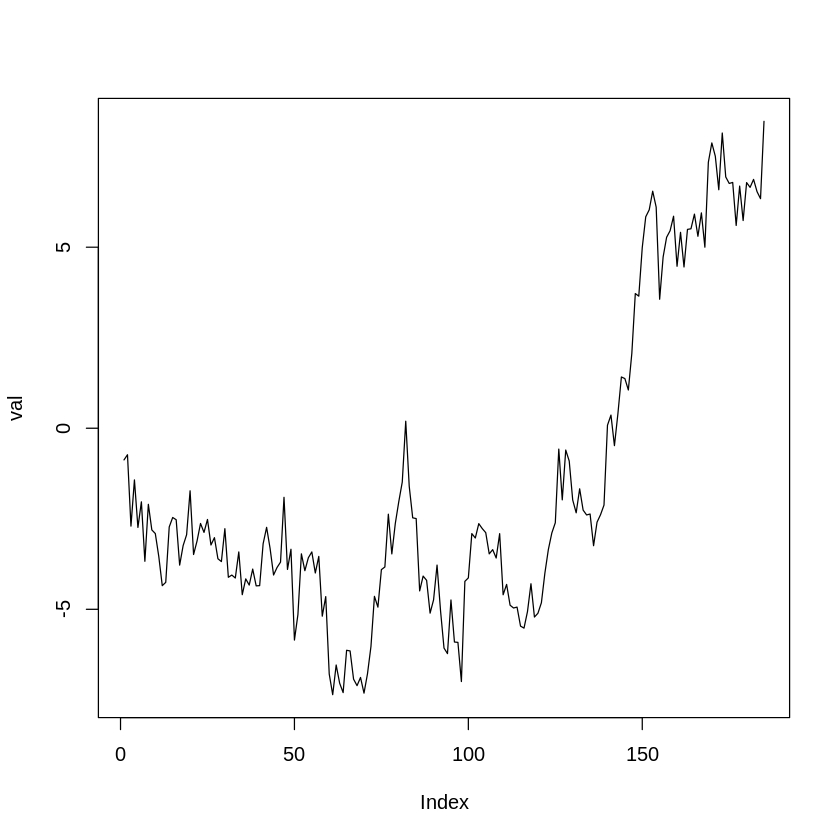

In [40]:
maxIter = 1e3 # always limit the total iterations allowed
val = vector(mode = 'numeric', length = maxIter)
val[1] = rnorm(1) ## initialize

k = 1
while (abs(val[k]) < 10 && k <= maxIter) {
  val[k + 1] = val[k] + rnorm(1)
  k = k + 1
}
val = val[1:k-1]

plot(val, type = 'l')

#### key words
The following key words are useful within loops:

- break - break out of the currently executing loop
- next - move to the next iteration immediately, without executing the rest of this iteration (continue in other languages such as C++)

Here is an example using next:



In [ ]:
for ( i in 1:10 ) {
  if (i %% 2 == 0) next
  cat(i,'\n')
}

1 
3 
5 
7 
9 


## Conditional execution

Often when writing functions we need to do different things depending on what data is passed in. This is known as conditional execution, and is accomplished using the if and/or else construct:

```
if (condition) {
  # code executed when condition is TRUE
} else {
  # code executed when condition is FALSE
}
```



#### if statements

The workhorse for conditional execution in `R` is the if statement.
In the syntax below, note the spacing around the condition enclosed in the parentheses.

In [41]:
if ( TRUE ) {  # this condition is hard-coded to TRUE and will also execute the if-block
  print('do something if true')
}

[1] "do something if true"


## Optional `else` block

Use an else to control the flow without separately checking the condition’s negation:



In [42]:
if ((2 + 2) == 5 ) {
  print('the statement is true')
} else {
  print('the statement is false')
}

[1] "the statement is false"


### `ifelse` function

ifelse() is a function that takes three vector arguments and returns a new vector. As you can see this is not the same as above

In [43]:
# Define a vector
x <- c(1, 2, 3, 4, 5)

# Use ifelse to create a new vector
y <- ifelse(x > 3, "large", "small")

y

[1] "small" "small" "small" "large" "large"

# What about if_else?

`if_else` comes from dplyr and works the same as ifelse except the output from the if_else should be of the same type

In [44]:
y <- if_else(x > 3, "large", 10) # does not like character OR number 
y

ERROR: ignored

In [45]:
y <- if_else(x > 3, "large", "small") # works if character AND character
y

[1] "small" "small" "small" "large" "large"

### if-else chain

For more complex cases, you may want to check multiple conditions:

In [46]:
a = -1
b = 1

if (a * b > 0) {
  print('Zero is not between a and b')
} else if ( a < b ) {
    smaller = a
    larger = b
} else {
    smaller = b
    larger  = a
}

c(smaller, larger)

[1] -1  1

## The wiki-link game
To illustrate how and when to write functions, we will write a program that plays the [wiki-link game](https://en.wikipedia.org/wiki/Wikipedia:Wiki-Link_Game). An abbreviate version of the rules are:

1. Pick a whole number between 1 and 8 -- call it $N$.
2. Pick a random page on Wikipedia by visiting [the random page page](https://en.wikipedia.org/wiki/Special:Random).
3. Now read the article until you reach the $N$th link.
  -  If you arrive at a page you have already visited since the start of a run, then game over (the ''infinite loop ending''). 
  - If your page doesn't have $N$ links, then game over. (the ''short page ending'').
  - If the $N$th link is a red link to edit a page which does not exist yet, then game over (the ''empty link ending'');
  - If you arrive at an off-site, non-Wikipedia page, then game over (the ''off-site ending''); more commonly you can choose to skip over external links.
  - ...otherwise, follow the link at go back to step 3...
4. How many pages can you visit?


Relative to what we have seen so far, this is advanced. To solve it, we will break the problem into smaller pieces which we can then tackle.

In [ ]:
play_wiki_link <- function(n) {
    current_url <- get_random_page()
    i <- 0
    seen_before <- c()
    while (TRUE) {
        print(current_url)
        print(i)
        flush.console()
        seen_before <- c(seen_before, current_url)
        nth_link <- get_nth_link(current_url, n) %>% filter_meta
        if (is.na(nth_link)) stop(str_c("no n-th link ", i))
        if (nth_link %in% seen_before) stop(str_c("infinite loop ", i))
        if (is_red_link(nth_link)) stop(str_c("red link ", i))
        current_url <- str_c("https://en.wikipedia.org", nth_link)
        i <- i + 1
    }
}

play_wiki_link(5)

ERROR: Error in get_random_page(): could not find function "get_random_page"
